DA323: MMDP-2 Course Assignment. Prepared by Heet Patel (R.No.: 220150010)

# Face2Speech: Finding the voice behind the face

Face2Speech paper ([link](https://www.isca-archive.org/interspeech_2020/goto20_interspeech.pdf)) proposes a multi-speaker TTS system that synthesizes speech with voice characteristics predicted from face images.

It consists of three separately trained modules: a speech encoder, a
multi-speaker text-to-speech (TTS), and a face encoder. The speech encoder outputs an embedding vector which is distinguishable from other speakers. The multi-speaker TTS synthesizes speech by using the embedding vector, and then the face
encoder outputs the embedding vector of a speaker from the
speaker’s face image.

### Motivation and connection with Multimodal learning.

In the classroom discussions, we came across the paper <b>Speech2Face</b>, where we learnt how facial features could be predicted from the speech of a person. That paper intrigued me a lot, and I thought if we can do that, why not the other way round, basically, why not predict the speech of a person using a facial image. So I proceeded to research upon the topic and I came across this paper Face2Speech, which aimed to target the exact same topic. So here I explain and present my understanding of the paper.



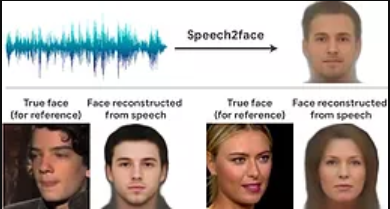

## Introduction

The paper explores the cross-modal relationship between facial and vocal features in human perception, proposing a DL framework to synthesize speech from face images.<u> Humans can infer characteristics like gender, age, and ethnicity from faces and voices due to shared biometric cues. </u>Leveraging advancements in deep neural network (DNN)-based text-to-speech (TTS) systems, the study integrates facial features into speech synthesis to enable intuitive speaker control. Existing methods like VAE-Loop and speaker recognition embeddings (d-vector/x-vector) demonstrate controllability of vocal traits, but this work bridges the gap with visual input.

The proposed Face2Speech framework uses three modules: a speech encoder, a multi-speaker TTS model, and a face encoder.<u> To overcome the lack of (text, speech, face image) datasets, it trains on separate (text, speech) pairs (VCTK, LibriTTS) and (face, speech) pairs (VoxCeleb2, VGGFace2).</u> The speech encoder extracts speaker embeddings, the TTS synthesizes speech from text and embeddings, and the face encoder aligns facial features with speech-derived embeddings. Experiments show synthesized speech quality comparable to using direct speech embeddings, validating cross-modal integration. This approach enables applications like visual speaker selection and emotion control without requiring voice samples.

## Related Work
Existing cross-modal synthesis approaches explore bidirectional voice-face relationships through techniques like predicting facial features from speech spectrograms (Oh et al.) ([Speech2Face link](https://doi.org/10.48550/arXiv.1905.09773)) or generating subjective voice impressions from faces (Ohsugi et al.) ([link](https://www.researchgate.net/publication/327388704_A_Comparative_Study_of_Statistical_Conversion_of_Face_to_Voice_Based_on_Their_Subjective_Impressions)). Some methods enable joint conversion of facial/acoustic features between speakers, while others focus on multi-modal TTS:

**-** Facial expression-driven synthesis: Székely et al. ([link](https://www.researchgate.net/publication/258217700_Predicting_synthetic_voice_style_from_facial_expressions_An_application_for_augmented_conversations)) developed systems that predict vocal styles from facial expressions.

**-** Lip-synced avatars: Schroeter et al. ([link](https://www.researchgate.net/publication/2565006_Multimodal_Speech_Synthesis)) created synchronized speech-face outputs with animated lips.

<b>Key distinction</b>: Unlike these methods, Face2Speech directly synthesizes speech with speaker-specific vocal characteristics predicted entirely from static face images, rather than relying on dynamic expressions, lip movements, or pre-recorded voice samples.

## Dataset

The study used VoxCeleb2 ([link](https://doi.org/10.48550/arXiv.1806.05622)) and VGGFace2 ([link](https://doi.org/10.48550/arXiv.1710.08092)) datasets as pairs of face images and speech to train a face encoder. Due to low-resolution videos in VoxCeleb2 causing cropping errors and loss of fine facial details, VGGFace2 images were preferred for higher resolution, while speech was sourced from VoxCeleb2. Training involved 5,993 speakers, and evaluation involved 118 speakers. Additionally, VCTK and LibriTTS datasets, containing cleaner speech, were used as pairs of text and speech with 847 speakers for training and 66 for evaluation, with all speech downsampled to 16 kHz.

## Face2Speech Model Architecture
The Face2Speech model architecture consists of three main components: a speech encoder, a multi-speaker TTS model, and a face encoder. The speech encoder extracts speaker embeddings from the input speech, while the TTS model synthesizes speech from text and speaker embeddings. The face encoder generates speaker embeddings from face images. The overall architecture is designed to enable the synthesis of speech with voice characteristics predicted from face images.

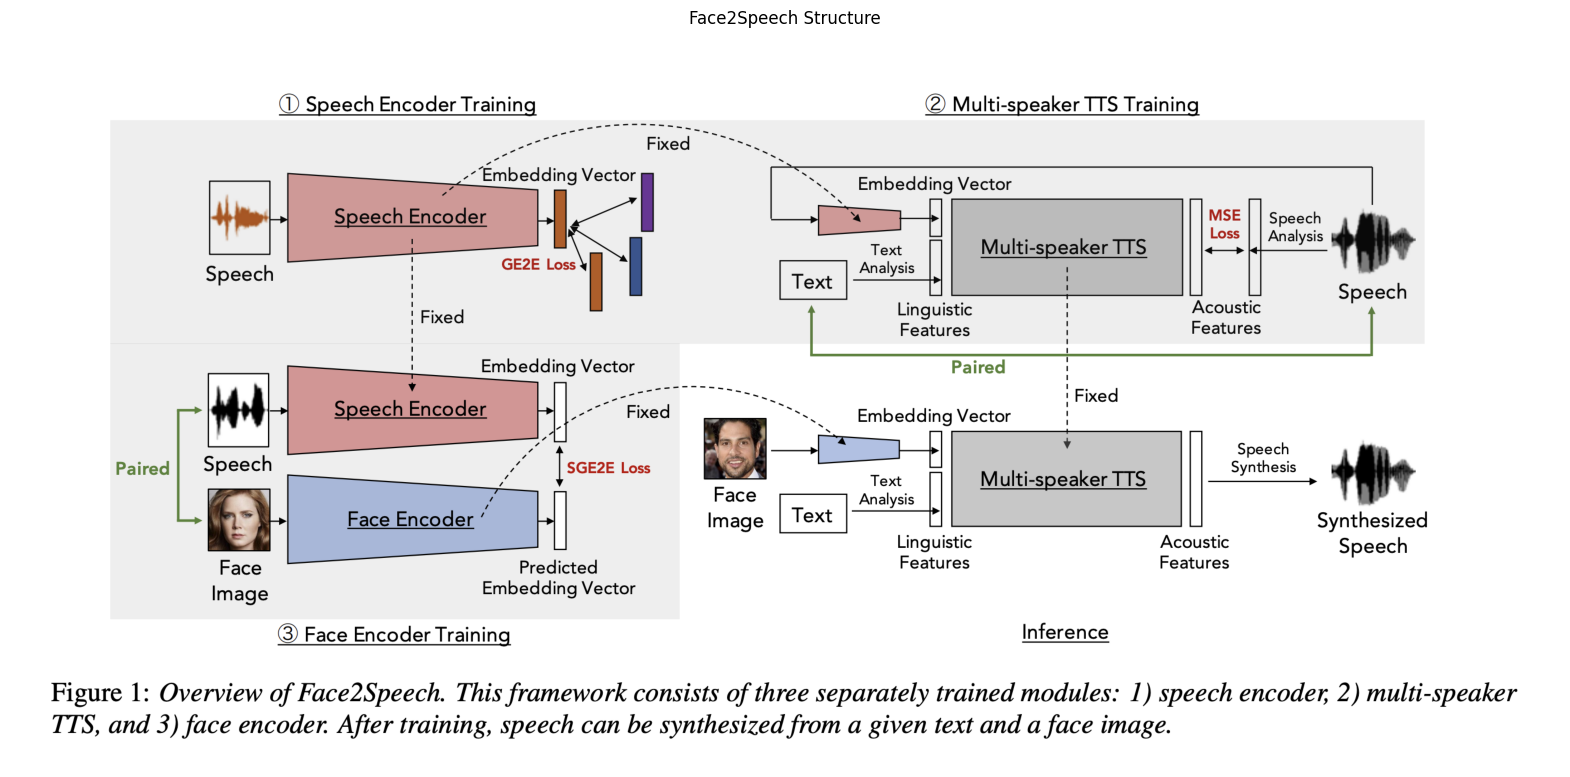

In [ ]:
# the structure of Face2Speech.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys

img_path = 'images/structure.png'
img = mpimg.imread(img_path)
plt.figure(figsize=(20, 50))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Face2Speech Structure')
plt.show()


### Speech Encoder

Embedding vectors, which capture the characteristics of speakers, have often been used for speaker verification. The speech encoder in our framework follows a method proposed by Wan et al. ([link](https://doi.org/10.48550/arXiv.1710.10467)).

A log-Mel spectrogram is fed to the speech encoder for extracting an embedding vector. In training the speech encoder, each mini-batch consists of M × N utterances; each of the N different speakers has M utterances. We use a weighted cosine similarity between centroids of the embedding vectors and the embedding vectors of the utterances in the mini-batch to create similarity matrix, and an end-to-end loss function over it to train the speech encoder. This is known as Generalised End-to-End (GE2E) loss.


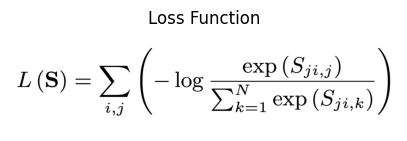

In [ ]:
# The loss function for speech encoder:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys

loss_img_path = 'images/loss.png'
img = mpimg.imread(loss_img_path)
plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Loss Function')
plt.show()

This loss function has an effect of making the cosine similarity of embedding vectors of the same speaker larger and those of the other speakers smaller.

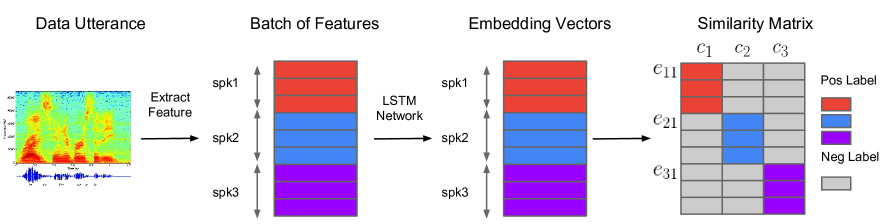

Generalised End to End loss demonstrated in the above image

##### Training the Speech Encoder
The length of window, hop size, and FFT were set to 400
(25 ms), 160 (10 ms), and 512 (64 ms) samples, respectively.
We used 40-dimensional log Mel-spectrograms as an input and
256-dimensional embedding vectors as an output. The speech
encoder consisted of three long short-term memory (LSTM)
layers with 768 hidden units and one linear output layer with
256 units. The activation function for hidden layers was tanh.
The number of speaker N and that of utterances M in each
mini-batch were set to 32 and 4, respectively. The number of
training epochs was 500, and the Adam optimizer with its
learning rate setting to 10−5 was used for the training.

### Multi-Speaker TTS
A statistical parametric speech synthesis as given in ([link](https://doi.org/10.1016/j.specom.2009.04.004)) for a multi-speaker TTS model that consists of duration and acoustic models is employed. The duration model outputs the number of frames from the joint vector of linguistic features per phoneme and embedding vectors per utterance, which are obtained by the speech encoder. On the otherhand, the acoustic model generates acoustic features (i.e., Mel-cepstral coefficients (MCEPs), log F0, and an aperiodicity measure) from the joint vector of linguistic features and the embedding vectors frame by frame. Both of the models are trained to minimize the mean squared error (MSE Loss) between the target features (i.e., the duration or acoustic feature) and output vectors of the models.

##### Training the Multi-Speaker TTS
The joint vector of 420-dimensional phoneme-wise linguistic
features (e.g., phoneme identity and accent type) and 256-
dimensional embedding vectors obtained from the speech encoder was fed into the duration model. We used WORLD
vocoder ([link](https://www.researchgate.net/publication/304671740_WORLD_A_Vocoder-Based_High-Quality_Speech_Synthesis_System_for_Real-Time_Applications))(D4C edition ([link](https://www.researchgate.net/publication/308183523_D4C_a_band-aperiodicity_estimator_for_high-quality_speech_synthesis))) for the acoustic feature extraction. The acoustic features consisted of 40-dimensional
MCEPs, log F0, an aperiodic measure, their dynamic features (i.e., ∆ and ∆∆), and voiced/unvoiced flag every 5 ms.
Namely, the dimensionality of the acoustic features was 127.
The joint vector of the linguistic features and the embedding
vectors per frame was fed into the acoustic model. The acoustic sequence transitions were generated by utilizing the explicit
relations between the static and dynamic features. The
WORLD vocoder was used for synthesizing a speech waveform
from the generated acoustic features. Inputs of the duration and
acoustic models were normalized to be within [0.01, 0.99], and
outputs of those were normalized to have zero mean and unit
variance using the training data. The embedding vectors were
averaged over each utterance. Both of the duration and acoustic models consisted of three bi-directional LSTM layers with
512 hidden units. The activation function for hidden layers was
tanh. The number of training epochs was 40, and the Adam optimizer with its learning rate setting to 10−4 was used for the
training.

### Face Encoder

Pairs of a face image and speech for training the face encoder. The input for the face encoder is a face image of a speaker and the output is the centroid of the embedding vector extracted from utterances of the speaker. A possible choice for the loss function of the face encoder would be the MSE Loss. But MSE loss will fail to capture the multimodal relationship between the face and voice. Therefore, we use a loss function similar to the one used in the speech encoder, over the weighted cosine similarity matrix between the embedding vectors of the face images and the centroids of the embedding vectors of the utterances. The authors of the paper name this loss function as supervised GE2E loss (SGE2E Loss), as this loss function is a supervised version of GE2E loss.

##### Training the Face Encoder
The input size of a face image was scaled to 160 × 160. The
value of each pixel is normalized to be within [−1.0, 1.0]. Flip
transformation was used for data augmentation. We used a pretrained face detection model1
for extracting face images from
VGGFace2. Images in which the recognition model failed to
detect a face were not used. The embedding vectors obtained
from the speech encoder were used as an output, which were averaged over all utterances from the same speaker. VGG19 was used as the network architecture. The number of training
epochs was 124, and the Adam optimizer with its learning rate
setting to 2.0 × 10−3 was used for the training.

## Evaluation

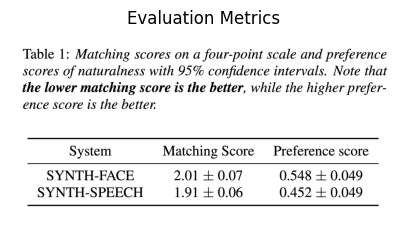

In [ ]:
# Evaluation metrics:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys

metrics_img_path = 'images/metrics.png'
img = mpimg.imread(metrics_img_path)
plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title('Evaluation Metrics')
plt.show()

The SYNTH-FACE is speech generated from the embedding vectors retrieved from the face image using the face encoder, while the SYNTH-SPEECH is speech generated from the embedding vectors retrieved from the speech encoder.

Matching score is mean score obtained by 30 listeners made to evaluate 10 samples of SYNTH-FACE and SYNTH-SPEECH. The listeners were asked to rate the similarity of the two samples on a scale of 1 to 4,  where 1: Match well, 2: Match moderately, 3: Match slightly, and 4: Not match.

Preference score is an AB test score obtained by 30 listeners made to evaluate 10 pairs of SYNTH-FACE and SYNTH-SPEECH samples. The listeners were asked to choose one of the two samples, and the preference score was calculated as the percentage of SYNTH-FACE samples chosen by the listeners.

## Results

In [ ]:
# Required imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Audio, display
import numpy as np
import os
import librosa
import librosa.display
import warnings

# Suppress specific librosa warnings that might be distracting
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

def display_image(image_path, title):
    """Display an image with a title."""
    try:
        img_size = (8, 6)
        img = mpimg.imread(image_path)
        plt.figure(figsize=img_size)
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.title(title)
        plt.show()
    except Exception as e:
        print(f"Error displaying image: {e}")

def play_audio(audio_path):
    """
    Display audio with play/pause controls and return audio data.
    Works with MP3, WAV, and other formats supported by librosa.
    """
    try:
        # Check if file exists
        if not os.path.exists(audio_path):
            print(f"File not found: {audio_path}")
            return None, None

        # Load audio file with librosa (handles MP3, WAV, etc.)
        y, sr = librosa.load(audio_path, sr=None)  # sr=None preserves the original sample rate

        # Create audio widget with controls
        audio_widget = Audio(data=y, rate=sr, autoplay=False)
        display(audio_widget)

        print(f"Audio loaded: {len(y)/sr:.2f} seconds, Sample rate: {sr} Hz")
        return y, sr
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None, None

def visualize_audio_waveform(y, sr, title="Audio Waveform"):
    """Visualize the audio waveform."""
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def visualize_audio_spectrogram(y, sr, title="Audio Spectrogram"):
    """Visualize the audio spectrogram."""
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

##### Adam Rodriguez

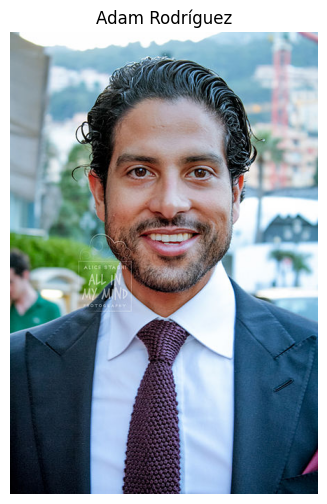

In [ ]:
# img
adam_img_path = 'demo/Adam_Rodríguez.jpg'
display_image(adam_img_path, 'Adam Rodríguez')

Audio loaded: 4.07 seconds, Sample rate: 16000 Hz


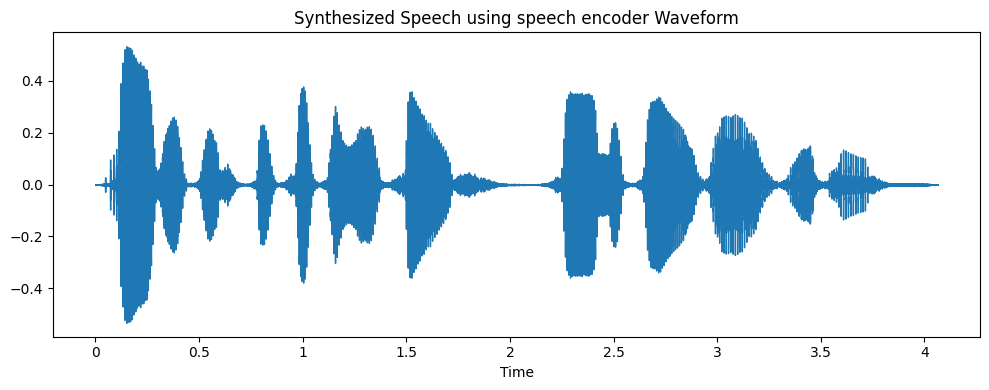

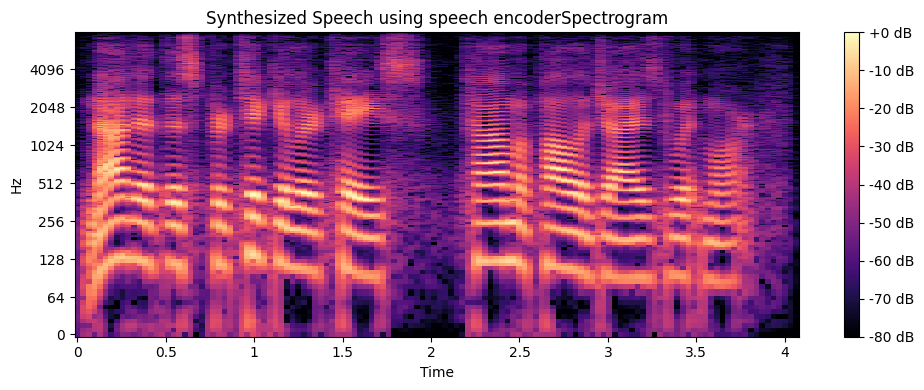

In [ ]:
# Synth Speech Audio
synth_audio_path = 'demo/adam_rodriguez__synth_speech.wav'
y_synth, sr_synth = play_audio(synth_audio_path)
if y_synth is not None:
    visualize_audio_waveform(y_synth, sr_synth, title="Synthesized Speech using speech encoder Waveform")
    visualize_audio_spectrogram(y_synth, sr_synth, title="Synthesized Speech using speech encoderSpectrogram")


Audio loaded: 3.15 seconds, Sample rate: 16000 Hz


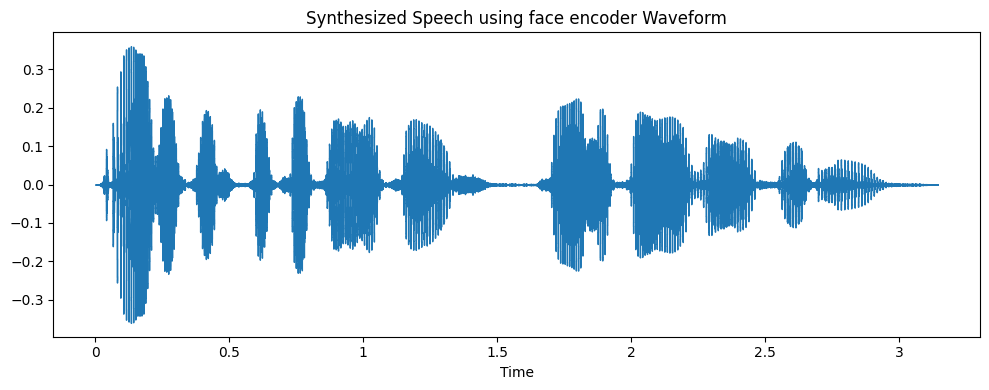

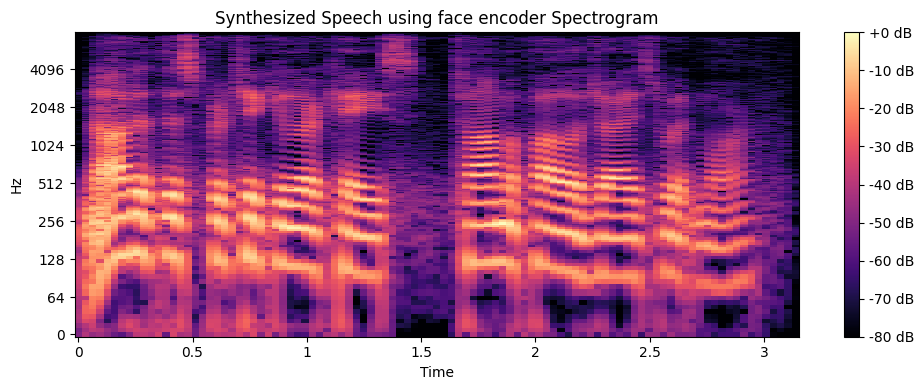

In [ ]:
# Synth Face Audio
synth_face_audio_path = 'demo/adam_rodriguez_synth_face.wav'
y_synth_face, sr_synth_face = play_audio(synth_face_audio_path)
if y_synth_face is not None:
    visualize_audio_waveform(y_synth_face, sr_synth_face, title="Synthesized Speech using face encoder Waveform")
    visualize_audio_spectrogram(y_synth_face, sr_synth_face, title="Synthesized Speech using face encoder Spectrogram")


In [ ]:
# Original Speech Audio
original_audio_path = 'demo/adam_rodriguez_original.mp3'
y_original, sr_original = play_audio(original_audio_path)

Audio loaded: 25.52 seconds, Sample rate: 44100 Hz


##### Amy Adams

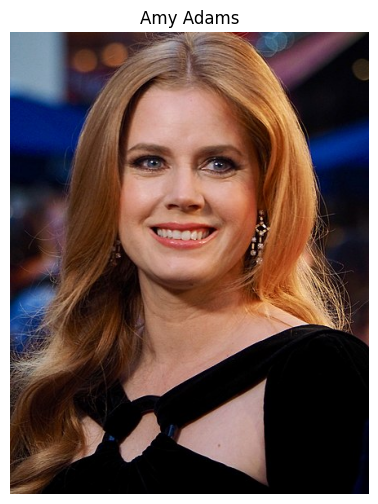

In [ ]:
# Face Image
face_img_path = 'demo/Amy_Adams.jpg'
display_image(face_img_path, 'Amy Adams')

Audio loaded: 3.69 seconds, Sample rate: 16000 Hz


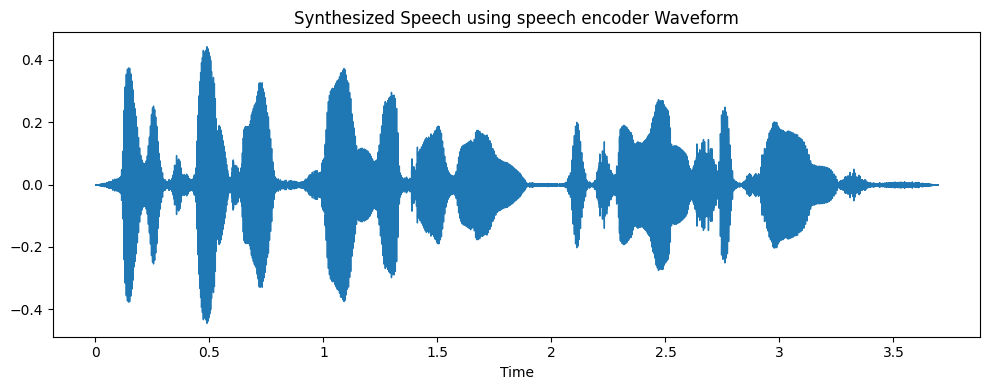

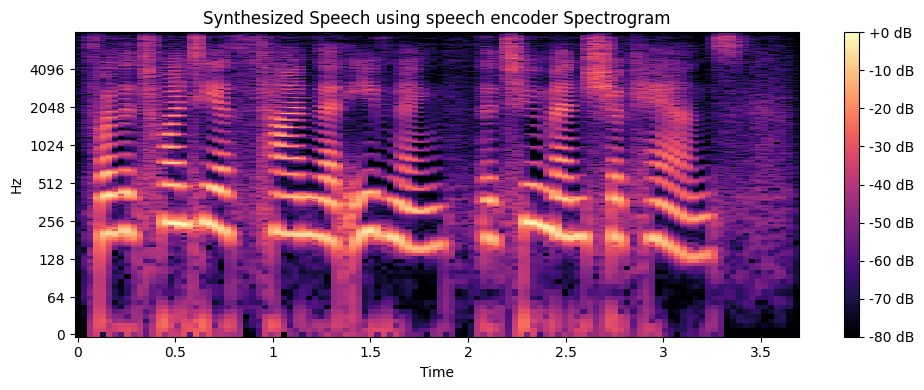

In [ ]:
# Synth Speech Audio
synth_audio_path = 'demo/amy_adams_synth_speech.wav'
y_synth, sr_synth = play_audio(synth_audio_path)
if y_synth is not None:
    visualize_audio_waveform(y_synth, sr_synth, title="Synthesized Speech using speech encoder Waveform")
    visualize_audio_spectrogram(y_synth, sr_synth, title="Synthesized Speech using speech encoder Spectrogram")

Audio loaded: 2.89 seconds, Sample rate: 16000 Hz


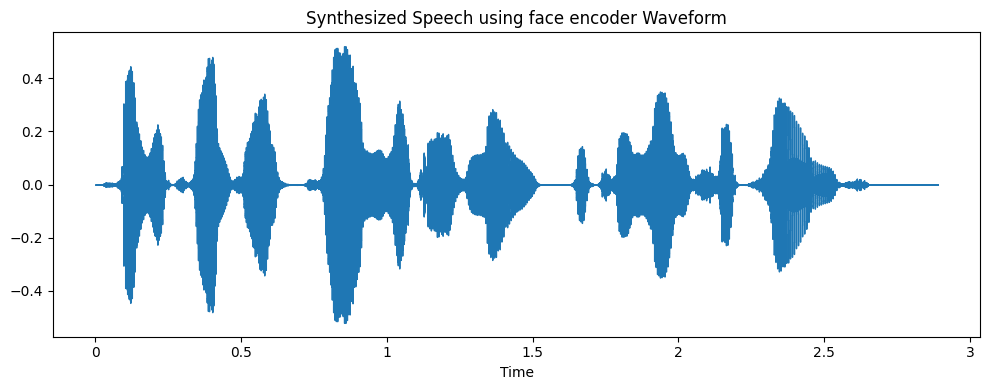

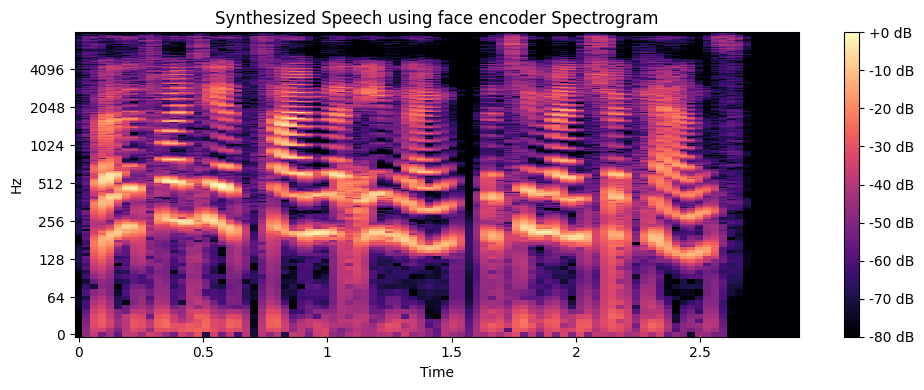

In [ ]:
# Synth Face Audio
synth_face_audio_path = 'demo/amy_adams_synth_face.wav'
y_synth_face, sr_synth_face = play_audio(synth_face_audio_path)
if y_synth_face is not None:
    visualize_audio_waveform(y_synth_face, sr_synth_face, title="Synthesized Speech using face encoder Waveform")
    visualize_audio_spectrogram(y_synth_face, sr_synth_face, title="Synthesized Speech using face encoder Spectrogram")

In [ ]:
# Original Speech Audio
original_audio_path = 'demo/amy_adams_original.mp3'
y_original, sr_original = play_audio(original_audio_path)


Audio loaded: 16.74 seconds, Sample rate: 44100 Hz


## Python notebook by Heet Patel, R.No.: 220150010, for DA323-MMDP2 course assignment.